In [205]:
!{sys.executable} -m pip install hdbscan


In [1]:
# Importamos todas las librerías necesarias
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
import hdbscan

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.feature_extraction import FeatureHasher
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_score

In [7]:
# Cargamos el Dataset
df= pd.read_csv('df_sin_codificar_actores.csv')

In [10]:
# Para la clusterización de las películas decidimos quedarnos con las columnas 'genero_1','director', 'actor_1', 'actor_2', 'actor_3'
df_cluster= df[[ 'genero_1','director', 'actor_1', 'actor_2', 'actor_3']]
df_cluster.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42988 entries, 0 to 42987
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   genero_1  42988 non-null  int64 
 1   director  41442 non-null  object
 2   actor_1   42988 non-null  object
 3   actor_2   42988 non-null  object
 4   actor_3   42988 non-null  object
dtypes: int64(1), object(4)
memory usage: 1.6+ MB


In [12]:
# Nos descemos de las filas con campos vacíos, que en este caso son 1546 películas que no tienen director
df_cluster= df_cluster.dropna()
df_cluster.info()

<class 'pandas.core.frame.DataFrame'>
Index: 41442 entries, 0 to 42987
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   genero_1  41442 non-null  int64 
 1   director  41442 non-null  object
 2   actor_1   41442 non-null  object
 3   actor_2   41442 non-null  object
 4   actor_3   41442 non-null  object
dtypes: int64(1), object(4)
memory usage: 1.9+ MB


In [13]:
# Desocdificamos los géneros desde el json 'codificación_generos.json'
import json

with open('codificacion_generos.json', 'r', encoding='utf-8') as f:
    generos_codificados = json.load(f)

generos_decodificados = {v: k for k, v in generos_codificados.items()}

df_cluster['genero_1'] = df_cluster['genero_1'].map(generos_decodificados)

In [14]:
# Creamos una nueva columna actores con los actores de las 3 columnas del dataset
df_cluster['actores']= df_cluster['actor_1'] + ', ' + df_cluster['actor_2'] + ', ' + df_cluster['actor_3']

In [20]:
# Eliminamos las columnas de actores
df_cluster.drop(['actor_1', 'actor_2', 'actor_3'], axis= 1, inplace=True)

In [21]:
df_cluster
# Nos quedamos con 3 columnas 'genero_1', 'director' y 'actores'

,genero_1,director,actores
0,Drama,Coralie Fargeat,"Demi Moore, Margaret Qualley, Dennis Quaid"
1,Drama,Arantxa Echevarría,"Carolina Yuste, Luis Tosar, Víctor Clavijo"
2,Acción,Todd Phillips,"Joaquin Phoenix, Lady Gaga, Brendan Gleeson"
3,Aventura,Chris Sanders,"Lupita Nyong'o, Pedro Pascal, Kit Connor"
4,Biopic,Icíar Bollaín,"Mireia Oriol, Urko Olazabal, Ricardo Gómez"
...,...,...,...
42983,Comedia dramática,Satyajit Ray,"Soumitra Chatterjee, Sharmila Tagore, Robi Ghosh"
42984,Drama,Andy Anderson (I),"John S. Davies, Marsha Dietlein, Meason Wiley"
42985,Comedia,Bruce McCulloch,"Natasha Henstridge, Luke Wilson, Kathleen Robe..."
42986,Comedia dramática,Benoit Lamy,"Richard Bohringer, Ute Lemper, Richard Bohringer"


In [22]:
# Utilizamos FeatureHasher que se usa para transformar datos categóricos (en este caso, nombres de directores) en representaciones numéricas.
# Hacemmos esto ya porque el número de datos únicos en la columna 'director' es demasiado grande para ser manejado por One-hot encoding.
# Creamos un objeto FeatureHasher configurado para generar 100 características (n_features=100) a partir de entradas de tipo string (input_type='string').
hasher = FeatureHasher(n_features=100, input_type='string')

# Extraemos los nombres de los directores de la columna 'director' del DataFrame df_cluster.
# Convertimos los nombres a tipo string y los almacenamos en una lista llamada directors_list.
directors_list = df_cluster['director'].astype(str).tolist()

# Aplicamos el hashing a la lista de nombres de directores.
# El método transform del FeatureHasher convierte la lista en una matriz dispersa de características.
hashed_features = hasher.transform([directors_list])

# Convertimos la matriz dispersa de características en un DataFrame de Pandas llamado hashed_df.
# Asignamos nombres a las columnas del DataFrame, usando el prefijo "director_" seguido del índice de cada característica.
hashed_df = pd.DataFrame(hashed_features.toarray(), columns = ['director_' + str(i) for i in range(0,100)])

# Combinamos el DataFrame original df_cluster con el nuevo DataFrame de características hash (hashed_df).
df = pd.concat([df_cluster, hashed_df], axis=1)

# Eliminamos la columna 'director' original del DataFrame, ya que ahora tenemos sus representaciones numéricas.
df = df.drop("director", axis=1)

In [23]:
# Hacemos el mismo procedimiento para la columna actores
actores_list = df_cluster['actores'].astype(str).tolist()

# Aplicamos el hashing a la columna 'director'
hashed_features = hasher.transform([actores_list])
hashed_df = pd.DataFrame(hashed_features.toarray(), columns = ['actor_' + str(i) for i in range(0,100)])

# Combinamos el resultado con el DataFrame original
df = pd.concat([df, hashed_df], axis=1)
df = df.drop("actores", axis=1) # Y nos desacemos de la columna actores original

In [24]:
# Aplicamos one-hot encoding a la columna 'genero_unico', ya que el número de géneros es más manejable por
df_encoded = pd.get_dummies(df, columns=['genero_1'], prefix='genero')

# Lo unimos a nuestro dataframe
df = pd.concat([df, df_encoded], axis=1)
df = df.drop(['genero_1'], axis=1) # Eliminamos la columna original

In [25]:
# Así es como queda nuestro dataframe
df

,director_0,director_1,director_2,director_3,director_4,director_5,director_6,director_7,director_8,director_9,...,genero_Fantasía,genero_Guerra,genero_Histórico,genero_Judicial,genero_Música,genero_Romántico,genero_Suspense,genero_Terror,genero_Western,genero_Épico
0,53.0,60.0,44.0,-96.0,-43.0,20.0,18.0,-43.0,86.0,22.0,...,False,False,False,False,False,False,False,False,False,False
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,False,False,False,False,False,False,False,False,False,False
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,False,False,False,False,False,False,False,False,False,False
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,False,False,False,False,False,False,False,False,False,False
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42983,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,False,False,False,False,False,False,False,False,False,False
42984,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,False,False,False,False,False,False,False,False,False,False
42985,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,False,False,False,False,False,False,False,False,False,False
42986,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,False,False,False,False,False,False,False,False,False,False


In [217]:
# Crear un diccionario para guardar los LabelEncoders
#label_encoders = {}

# Codificar las columnas categóricas
#for col in df_cluster.columns:
 #   if df_cluster[col].dtype == object:  # Verificar si es categórica
  #      le = LabelEncoder()
  #      df_cluster[col] = le.fit_transform(df_cluster[col])
   #     label_encoders[col] = le  # Guardar el LabelEncoder en el diccionario

In [218]:
# Graficamos la correlación entre las variables
# Calcular la matriz de correlación
#correlation_matrix = df_cluster.corr()

# Graficar la matriz de correlación
# plt.figure(figsize=(10, 8))
# sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
# plt.title('Matriz de Correlación')
# plt.show()

In [26]:

# StandardScaler estandariza las características eliminando la media y escalando a la varianza unitaria.
# Esto es importante para que todas las características tengan un rango similar y no haya problemas en algoritmos basados en distancias.
scaler = StandardScaler()

# Ajusta el escalador a los datos (calcula media y desviación estándar) y luego transforma los datos.
# El resultado es un array de NumPy con los datos escalados.
X_scaled = scaler.fit_transform(df)

# Conviertimos el array escalado de nuevo a un DataFrame de Pandas, manteniendo los mismos nombres de columna.
X_scaled = pd.DataFrame(X_scaled, columns=df.columns)

# Rellenamos posibles valores NaN con 0. Esto evita problemas en algoritmos y modelos posteriores.
X_scaled.fillna(0, inplace=True)

# Reducimos la dimensionalidad con PCA
# PCA (Principal Component Analysis) reduce la dimensionalidad de los datos transformándolos en un conjunto de componentes principales.
# Estos componentes son combinaciones lineales de las características originales y capturan la mayor varianza posible con menos dimensiones.
pca = PCA(n_components=100)

# Ajustamos PCA a los datos escalados y los transforma en 100 componentes principales.
X_pca = pca.fit_transform(X_scaled)

In [ ]:
# Creamos un DataFrame con las componentes principales
pca_df = pd.DataFrame(X_pca, columns=[f'pca_{i+1}' for i in range(X_pca.shape[1])])

In [28]:
pca_df

,pca_1,pca_2,pca_3,pca_4,pca_5,pca_6,pca_7,pca_8,pca_9,pca_10,...,pca_91,pca_92,pca_93,pca_94,pca_95,pca_96,pca_97,pca_98,pca_99,pca_100
0,1.671953,0.458193,0.145258,0.042839,0.034183,-0.002830,-0.044357,-0.014572,-0.015952,-0.020303,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.671953,0.458193,0.145258,0.042839,0.034183,-0.002830,-0.044357,-0.014572,-0.015952,-0.020303,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.580756,-1.677713,2.456863,0.295753,0.201105,-0.015471,-0.216298,-0.067033,-0.070963,-0.086262,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-0.461618,-0.886301,-1.199448,-2.259582,3.112823,-0.107216,-0.840042,-0.215983,-0.209058,-0.228396,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.420866,-0.724897,-0.704544,-0.444957,-0.533562,0.059598,2.326034,4.423620,-2.566284,-1.027587,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41437,-0.481170,-0.977648,-1.700802,3.176322,0.804795,-0.049304,-0.534652,-0.149975,-0.150894,-0.172197,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
41438,1.671953,0.458193,0.145258,0.042839,0.034183,-0.002830,-0.044357,-0.014572,-0.015952,-0.020303,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
41439,-1.380352,1.670758,0.313302,0.083588,0.064884,-0.005297,-0.081115,-0.026309,-0.028584,-0.035991,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
41440,-0.481170,-0.977648,-1.700802,3.176322,0.804795,-0.049304,-0.534652,-0.149975,-0.150894,-0.172197,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [40]:
df.fillna(0, inplace=True)

* La elección de HDBSCAN se ha debido a su capacidad para manejar la complejidad de los datos, incluyendo clusters de diferentes formas y densidades, sin la necesidad de especificar el número de clusters a priori. Las pruebas realizadas con KMeans y DBSCAN no han ofrecido resultados satisfactoriosi, imagino que debido a las limitaciones de estos algoritmos en relación a la estructura de los datos. HDBSCAN se ha adaptado mejor a la estructura de los datos. 

* K-Means, se testeo con diferentes números de clusters, pero los grupos que hacía no tenían mucho sentido, a demás los centroides estaban todos juntos, no habia apenas separación entre ellos y los puntos estaban todos muy juntos unos de otros.

* DBSCAN solo encontraba un cluster y algun outlier suelto, no conseguí nada más con el.

In [29]:
# Aplicamos HDBSCAN
clusterer = hdbscan.HDBSCAN(min_cluster_size=15, min_samples=5)
cluster_labels = clusterer.fit_predict(pca_df) # o todas las columnas que quieras usar


c:\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [96]:
# Creamos un DataFrame con las etiquetas de cluster, usando el mismo índice
cluster_df = pd.DataFrame({'cluster': cluster_labels})
cluster_df.value_counts().reset_index()

,cluster,count
0,22,12719
1,23,8527
2,21,4456
3,20,2746
4,19,2299
5,18,1923
6,17,1898
7,16,1309
8,15,1191
9,14,1042


In [42]:
# Utilizamos los clusters y el dataset pca para crear una visualización de los datos
pca_df = pd.concat((pca_df, cluster_df), axis=1)

Utilizamos TSNE porque es una herramienta que nos proporciona una visualización clara y concisa de datos de alta dimensión en 2D. Esta visualización es clave para entender mejor los datos, validar los resultados de otros procesos y presentar conclusiones de manera más intuitiva. Es de tipo no lineal, adecuada para relaciones complejas, permite visualizar clusters, validar resultados y comprender mejor los datos.

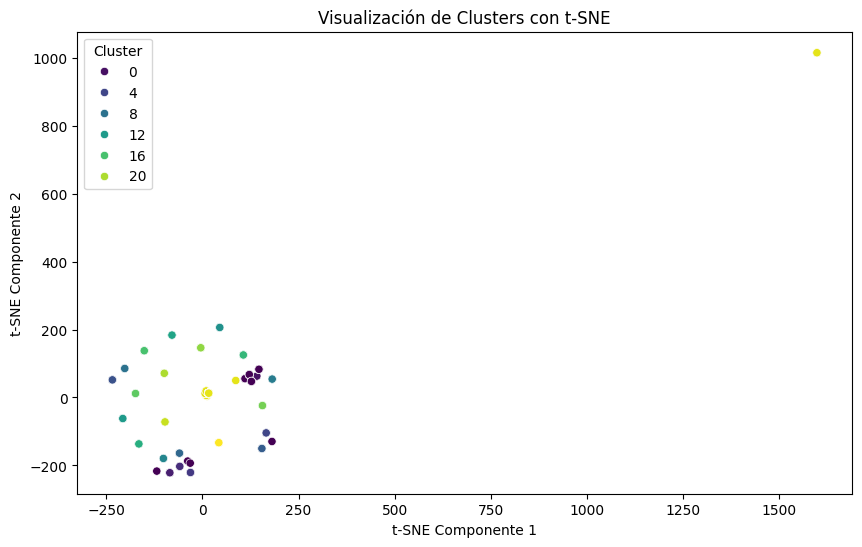

In [43]:
from sklearn.manifold import TSNE

# Reducimos la dimensionalidad a 2D para visualización
tsne = TSNE(n_components=2, random_state=42, perplexity = 30)
tsne_features = tsne.fit_transform(pca_df.select_dtypes(include=['float64']))

# Creamos un DataFrame con las componentes t-SNE
tsne_df = pd.DataFrame(tsne_features, columns=['tsne_1', 'tsne_2'])

# Combinamos con el dataframe original
pca_df = pd.concat([pca_df, tsne_df], axis = 1)

# Gráfica de dispersión con colores según el cluster
plt.figure(figsize=(10, 6))
sns.scatterplot(x='tsne_1', y='tsne_2', hue='cluster', palette='viridis', data=pca_df)
plt.title('Visualización de Clusters con t-SNE')
plt.xlabel('t-SNE Componente 1')
plt.ylabel('t-SNE Componente 2')
plt.legend(title='Cluster')
plt.show()

"La visualización t-SNE muestra que los datos se agrupan principalmente en un conjunto denso de clusters, con el cluster 20 claramente separado como un outlier. Esto sugiere que la mayoría de los datos comparten características similares, mientras que el cluster 20 podría representar una categoría distinta o casos atípicos."

In [ ]:
# Vovemos a cargar el dataset completo para unirle la columna clusters y utilizarlo en la página de recomendaciones
df= pd.read_csv('df_sin_codificar_actores.csv')
df

,Unnamed: 0,titulo,fecha_streno,duracion,genero_1,genero_2,genero_3,director,actor_1,actor_2,actor_3,medios_rate,usuarios_rate,sensacine_rate,sinopsis,sensacine_opinion,dia,mes,ano,genero_unico
0,0,La sustancia,11 de octubre de 2024,140.0,15,30,15,Coralie Fargeat,Demi Moore,Margaret Qualley,Dennis Quaid,NaN,3.9,4.5,Elisabeth Sparkle (Demi Moore) es una actriz c...,"Coralie Fargeat dio un golpe sobre la mesa, de...",11.0,10.0,2024.0,45
1,1,La infiltrada,11 de octubre de 2024,118.0,15,15,15,Arantxa Echevarría,Carolina Yuste,Luis Tosar,Víctor Clavijo,NaN,3.0,4.0,La película La infiltrada (Arantxa Echevarria)...,"Durante ocho años, Elena Tejada respondió al n...",11.0,10.0,2024.0,15
2,2,Joker : Folie à Deux,4 de octubre de 2024,139.0,0,15,28,Todd Phillips,Joaquin Phoenix,Lady Gaga,Brendan Gleeson,3.1,2.8,4.0,Secuela de la película de 2019 dirigida por To...,Cuando Joker se estrenó -y ganó el León de Oro...,4.0,10.0,2024.0,43
3,3,Robot salvaje,11 de octubre de 2024,102.0,3,1,8,Chris Sanders,Lupita Nyong'o,Pedro Pascal,Kit Connor,NaN,4.2,4.5,Un robot naufraga en una isla deshabitada dond...,Un robot y un zorro tienen que enseñar a volar...,11.0,10.0,2024.0,12
4,4,Soy Nevenka,27 de septiembre de 2024,117.0,4,15,4,Icíar Bollaín,Mireia Oriol,Urko Olazabal,Ricardo Gómez,2.9,3.1,3.5,Película dramática inspirada en el caso real d...,Después de narrar la historia de Maixabel Lasa...,27.0,9.0,2024.0,19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42983,49165,Días y noches en el bosque,NaN,115.0,9,15,9,Satyajit Ray,Soumitra Chatterjee,Sharmila Tagore,Robi Ghosh,NaN,NaN,NaN,"Cuatro amigos que viven en Calcuta, muy difere...",NaN,NaN,NaN,NaN,24
42984,49168,Detention,NaN,86.0,15,15,15,Andy Anderson (I),John S. Davies,Marsha Dietlein,Meason Wiley,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15
42985,49169,De tal perro tal amo,NaN,91.0,8,8,8,Bruce McCulloch,Natasha Henstridge,Luke Wilson,Kathleen Robertson,2.6,NaN,NaN,"Andy acaba de romper con su novia, con la cual...",NaN,NaN,NaN,NaN,8
42986,49170,Combat de fauves,NaN,90.0,9,9,9,Benoit Lamy,Richard Bohringer,Ute Lemper,Richard Bohringer,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9


In [90]:
# Decodificamos las columnas género
with open('codificacion_generos.json', 'r', encoding='utf-8') as f:
    generos_codificados = json.load(f)

generos_decodificados = {v: k for k, v in generos_codificados.items()}

df['genero_1'] = df['genero_1'].map(generos_decodificados)
df['genero_2'] = df['genero_2'].map(generos_decodificados)
df['genero_3'] = df['genero_3'].map(generos_decodificados)

In [ ]:
# Eliminamos las filas que no tinen director
df= df.dropna(subset='director')
len(df)

41442

In [ ]:
# Unimos los clusters a nuestro dataset 
df.reset_index(drop=True, inplace=True)
df_cluster.reset_index(drop=True, inplace=True)

df = df.join(df_cluster, how='left')


In [94]:
df

,Unnamed: 0,titulo,fecha_streno,duracion,genero_1,genero_2,genero_3,director,actor_1,actor_2,...,medios_rate,usuarios_rate,sensacine_rate,sinopsis,sensacine_opinion,dia,mes,ano,genero_unico,cluster
0,0,La sustancia,11 de octubre de 2024,140.0,Drama,Terror,Drama,Coralie Fargeat,Demi Moore,Margaret Qualley,...,NaN,3.9,4.5,Elisabeth Sparkle (Demi Moore) es una actriz c...,"Coralie Fargeat dio un golpe sobre la mesa, de...",11.0,10.0,2024.0,45,22
1,1,La infiltrada,11 de octubre de 2024,118.0,Drama,Drama,Drama,Arantxa Echevarría,Carolina Yuste,Luis Tosar,...,NaN,3.0,4.0,La película La infiltrada (Arantxa Echevarria)...,"Durante ocho años, Elena Tejada respondió al n...",11.0,10.0,2024.0,15,22
2,2,Joker : Folie à Deux,4 de octubre de 2024,139.0,Acción,Drama,Romántico,Todd Phillips,Joaquin Phoenix,Lady Gaga,...,3.1,2.8,4.0,Secuela de la película de 2019 dirigida por To...,Cuando Joker se estrenó -y ganó el León de Oro...,4.0,10.0,2024.0,43,21
3,3,Robot salvaje,11 de octubre de 2024,102.0,Aventura,Animación,Comedia,Chris Sanders,Lupita Nyong'o,Pedro Pascal,...,NaN,4.2,4.5,Un robot naufraga en una isla deshabitada dond...,Un robot y un zorro tienen que enseñar a volar...,11.0,10.0,2024.0,12,19
4,4,Soy Nevenka,27 de septiembre de 2024,117.0,Biopic,Drama,Biopic,Icíar Bollaín,Mireia Oriol,Urko Olazabal,...,2.9,3.1,3.5,Película dramática inspirada en el caso real d...,Después de narrar la historia de Maixabel Lasa...,27.0,9.0,2024.0,19,15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41437,49165,Días y noches en el bosque,NaN,115.0,Comedia dramática,Drama,Comedia dramática,Satyajit Ray,Soumitra Chatterjee,Sharmila Tagore,...,NaN,NaN,NaN,"Cuatro amigos que viven en Calcuta, muy difere...",NaN,NaN,NaN,NaN,24,20
41438,49168,Detention,NaN,86.0,Drama,Drama,Drama,Andy Anderson (I),John S. Davies,Marsha Dietlein,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15,22
41439,49169,De tal perro tal amo,NaN,91.0,Comedia,Comedia,Comedia,Bruce McCulloch,Natasha Henstridge,Luke Wilson,...,2.6,NaN,NaN,"Andy acaba de romper con su novia, con la cual...",NaN,NaN,NaN,NaN,8,23
41440,49170,Combat de fauves,NaN,90.0,Comedia dramática,Comedia dramática,Comedia dramática,Benoit Lamy,Richard Bohringer,Ute Lemper,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9,20


In [95]:
# Guardamos nuestro dataset para que lo utilice nuestra web recomendadora.
df.to_csv('df_recomendador3.csv')